In [1]:
import sys
sys.path.append('./../hyperAFM')
sys.path.append('./../Jessica')
sys.path.append('./../Data')

import numpy as np
from util import HyperImage, load_ibw, HyperSlice
from gen_features import get_hyper_peaks
from PCAsynthetic import makefeaturematrix, stdfeature
import FindPeaks 
#for standardizing 
from sklearn.preprocessing import scale

#PCA packages
from sklearn.decomposition import PCA as sklearnPCA
from matplotlib.mlab import PCA

#linear regression package
from sklearn import linear_model 

#stats/math
import math
from scipy import stats 

#3-D plot
from mpl_toolkits.mplot3d import Axes3D

#import image alignment
from scipy import signal, optimize
from scipy.ndimage import rotate
from skimage.measure import compare_ssim as ssim
from skimage.feature import register_translation
from scipy.ndimage import fourier_shift
from scipy.optimize import minimize
from imagealignment import *

#error metrics
from sklearn.metrics import mean_squared_error 

import matplotlib.pyplot as plt
%matplotlib inline

## Import Images

In [2]:
#import hyperspectral image 
hyperimage = HyperImage('./../../Desktop/20170706_0712_0726_P3HTPMMA_hyper/Film10_0026.txt')
hyper = hyperimage.hyper_image
hypertopo = hyperimage.channel_data[:,:,0]
#flatten
hypertopo = signal.detrend(hypertopo, axis=1, type="linear")
wavelengths = hyperimage.wavelength_data

#import second hyperspectral image
hyperimage1 = HyperImage('./../../Desktop/20170706_0712_0726_P3HTPMMA_hyper/Film10_0005.txt')
hyper1 = hyperimage1.hyper_image
hypertopo1 = signal.detrend(hyperimage1.channel_data[:,:,0], axis=1, type = 'linear')
wavelengths = hyperimage1.wavelength_data

#import corresponding cAFM image
cAFMimage = load_ibw('./../../Desktop/20170724_0725_0726_PMMAP3HT_cAFM/cAFM3_0000.ibw')
cAFMtopo = cAFMimage[:,:,0]
cAFMtopo_mean = cAFMtopo.mean()
#flatten
cAFMtopo = signal.detrend(cAFMtopo, axis=1, type="linear")
cAFM = cAFMimage[:,:,3]
#store cAFM values in list. 
cAFMlist = cAFM.reshape((65536,))

#import second corresponding cAFM image
cAFMimage1 = load_ibw('./../../Desktop/20170724_0725_0726_PMMAP3HT_cAFM/Film10cAFM_0001.ibw')
cAFMtopo1 =signal.detrend(cAFMimage1[:,:,0], axis = 1, type = "linear")
cAFM1 = cAFMimage1[:,:,3]
cAFMlist1 = cAFM1.reshape((65536,))

#laser power spectrum
laser = np.loadtxt('./../Data/Q0148.txt', delimiter = '\t' )

In [ ]:
laser = np.flip(laser, 0)
plt.plot(laser[:,0], laser[:,1])

In [ ]:
#laser powers corresponding to 8 peaks used in PCA
list_laser = [laser[32,1], laser[74,1], laser[87,1], laser[94,1], laser[118,1], laser[153,1], laser[167,1], laser[208,1]] 

## Functions for plotting

In [3]:
def showsave(img, filename, cmap = 'viridis'):
    fig = plt.imshow(img, cmap = cmap)
    imgstd = img.std()
    imgmean = img.mean()
    ll = imgmean - (2*imgstd)
    ul = imgmean + (2*imgstd)
    plt.clim(ll,ul)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    #plt.colorbar()
    plt.savefig(filename + '.png')
    return 

def scatter(x,y, invert = True):
    plt.scatter(x, y)
    if invert:
        plt.gca().invert_xaxis()

# Images for Figures

In [ ]:
showsave(hypertopo, 'hypertopo')

In [ ]:
hyper1750 = HyperSlice(hyperimage, 1747, 1755)*10**6
showsave(hyper1750, '1750slice')

In [ ]:
hyper832 = HyperSlice(hyperimage,827,837)*10**6
showsave(hyper832, '832slice')

In [ ]:
import matplotlib.cm as cm

In [ ]:
#get random points on image
np.random.seed(2)
n = 10
xs = []
ys = []
for i in range(n): 
    x = np.random.randint(0,256)
    y = np.random.randint(0,256)
    xs.append(x)
    ys.append(y)

#xs = [50, 55, 109, 145, 15, 199, 38, 120]
#ys = [185, 65, 244, 85, 30, 222, 140, 5]


fig, ax = plt.subplots()
cax = ax.imshow(HyperSlice(hyperimage, 1747, 1755)*10**6, cmap = 'viridis')
cax.axes.get_xaxis().set_visible(False)
cax.axes.get_yaxis().set_visible(False)

img = HyperSlice(hyperimage, 1747, 1755)*10**6
mean = img.mean()
std= img.std()
ll = mean - (2*std)
ul = mean + (2*std)
cbar = fig.colorbar(cax)
cbar.set_clim(ll,ul)
for x,y in zip(xs,ys):
        ax.scatter(x,y, marker='D', s = 50)

colormap = plt.cm.gnuplot
colorst = [colormap(i) for i in np.linspace(0, 0.8,len(ax.collections))]       
for t,j1 in enumerate(ax.collections):
    j1.set_color(colorst[t])
fig.savefig('1750slice_pts')

In [ ]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
for i in range(n):
    ax1.plot(hyperimage.wavelength_data, hyper[xs[i],ys[i],:]*10**6+40*i)
ax1.set_xlabel('Wavenumber (cm$^{-1}$)', fontsize=16)
ax1.set_ylabel('Intensity (a.u.)', fontsize=16)
fig1.gca().invert_xaxis()
colormap = plt.cm.gnuplot
colors = [colormap(i) for i in np.linspace(0,0.8,len(ax1.lines))]
for i, j in enumerate(ax1.lines):
    j.set_color(colors[i])

fig1.savefig('ptspect')

In [ ]:
fig = plt.figure()
plt.plot(hyperimage.wavelength_data, averagespectrum*10**6, color = 'black')
plt.scatter(list_wavenumber, averagespectrum[indices]*10**6, color = 'blue')
plt.gca().invert_xaxis()
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')
    tick.label1.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(14)
    tick.label1.set_fontweight('bold')
plt.xlabel('Wavenumber cm$^{-1}$', fontsize=16, fontweight='bold')
plt.ylabel('Intensity (a.u.)', fontsize=16, fontweight='bold')
fig.savefig('avgspec')

# Image Registration

## Symmetric Diffeomorphic Registration

In [ ]:
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.imaffine import AffineRegistration
from dipy.align.metrics import SSDMetric, CCMetric, EMMetric
import dipy.align.imwarp as imwarp
from dipy.viz import regtools

In [ ]:
moving = cAFMtopo
static = hypertopo

dim = static.ndim
metric = SSDMetric(dim)

level_iters = [200, 100, 50, 25]

sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter = 50)
mapping = sdr.optimize(static, moving)
warped_moving = mapping.transform(moving, 'linear')
regtools.overlay_images(static, warped_moving, 'Static','Overlay','Warped moving',
   'direct_warp_result.png')


In [ ]:
mapping = sdr.optimize(static,moving)

## Affine Registration

want to start with images as close to solution as possible

In [4]:
static = hypertopo
moving = cAFMtopo

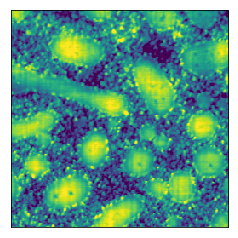

In [5]:
showsave(moving, 'moving')

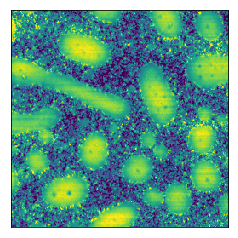

In [6]:
showsave(static, 'static')

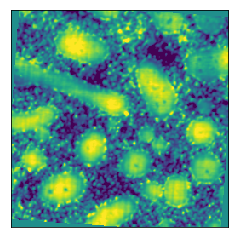

In [7]:
rotated = rot(cAFMtopo, deg = -4)
cAFMrotated = rot(cAFM, deg = -4)
showsave(rotated, 'rotated')

In [8]:
import numpy as np
from dipy.viz import regtools
from dipy.align.imaffine import (AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (AffineTransform2D,
                                   RigidTransform2D,
                                   RotationTransform2D,
                                  ScalingTransform2D, 
                                  TranslationTransform2D)

First, translate the images in x-y space

In [9]:
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)
level_iters = [10000, 1000, 100]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]
affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


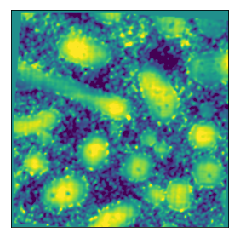

In [10]:
transform = TranslationTransform2D()
params0= None
static = hypertopo
moving = rotated
translation = affreg.optimize(static, moving, transform, params0, starting_affine=None)
transformed = translation.transform(moving)
cAFM_transformed = translation.transform(cAFMrotated)
showsave(transformed, 'translation')

Now do rigid translation

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


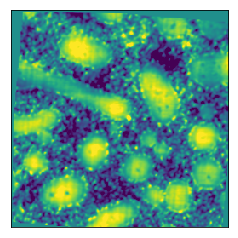

In [11]:
starting_affine = translation.affine
transform = RigidTransform2D() 
rigid = affreg.optimize(static, moving, transform, params0, starting_affine = starting_affine)
transformed = rigid.transform(moving)
cAFM_transformed = rigid.transform(cAFMrotated)
showsave(transformed, 'rigid')

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


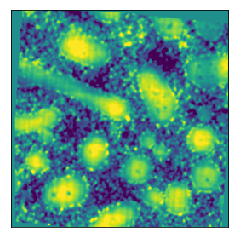

In [12]:
starting_affine = rigid.affine
transform = AffineTransform2D()
affine = affreg.optimize(static, moving, transform, params0, starting_affine = starting_affine)
transformed = affine.transform(moving)
cAFM_transformed = affine.transform(cAFMrotated)
showsave(transformed, 'affine2')

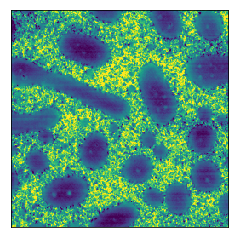

In [13]:
error = transformed - static
showsave(error, 'alignment_error')

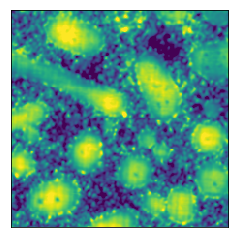

In [14]:
showsave(transformed[20:245, 20:245], 'affine2_crop')

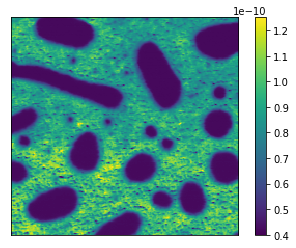

In [15]:
fig = plt.imshow(cAFM[35:245, 25:245])
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.clim(0.4e-10,1.25e-10)
plt.colorbar()
plt.savefig('cAFM_crop')

In [ ]:
fig = plt.imshow(cAFM_transformed[35:245, 25:245])
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.clim(0.4e-10,1.25e-10)
plt.colorbar()
plt.savefig('cAFM_transformedcrop')

In [ ]:
cAFMstd = cAFMtopo.std()
cAFMmean = cAFMtopo.mean()
ll = cAFMmean - (2*cAFMstd)
ul = cAFMmean + (2*cAFMstd)
fig = plt.imshow(cAFMtopo+cAFMmean)
plt.clim(ll,ul)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('cAFMtopo.png')

In [ ]:
hyperstd = hypertopo.std()
hypermean = hypertopo.mean()
ll = hypermean - (2*hyperstd)
ul = hypermean + (2*hyperstd)
fig = plt.imshow(hypertopo)
plt.clim(ll, ul)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('hypertopo.png')

### Register other set of images with affine transformation: 
first rotate by 4 deg, then put through translation, rigid, and affine transformations as above.
images are nicely registered. 

In [ ]:
rotated = rot(cAFMtopo1, deg = 4)
cAFMrotated2 = rot(cAFM1, deg = 4)

In [ ]:
static1 = hypertopo1
moving1 = cAFMtopo1
rotated1 = rot(cAFMtopo1, deg = 4)
moving1 = rotated1
cAFMrotated1 = rot(cAFM1, deg = 4)
transform = TranslationTransform2D()
params0= None
static = hypertopo1
moving = rotated1
translation = affreg.optimize(static1, moving1, transform, params0, starting_affine=None)
transformed = translation.transform(moving1)
cAFM_transformed = translation.transform(cAFMrotated1)
starting_affine = translation.affine
transform = RigidTransform2D() 
rigid = affreg.optimize(static1, moving1, transform, params0, starting_affine = starting_affine)
transformed = rigid.transform(moving1)
cAFM_transformed = rigid.transform(cAFMrotated1)
starting_affine = rigid.affine
transform = AffineTransform2D()
affine = affreg.optimize(static1, moving1, transform, params0, starting_affine = starting_affine)
transformed = affine.transform(moving1)
cAFM_transformed = affine.transform(cAFMrotated1)
showsave(transformed, 'affine2')

In [ ]:
showsave(cAFM_transformed[60:225, 45:250], 'transformed2')

In [ ]:
showsave(transformed[60:225, 45:250], 'transformed2')

In [ ]:
cAFM_transformed2 = cAFMrotated[60:225, 45:250]
showsave(hypertopo1[60:225, 45:250], hypertopo1crop)

In [ ]:
cAFM2 = cAFMtransformed

##### shift & rotate; then crop edges from image registration out

In [ ]:
offimg_shift, offimg_rot, deg_opt, cAFMrot = shiftandrotate(hypertopo, cAFMtopo, cAFM, tol=1e-14, guessang = -1)
cAFMrot_crop = offimg_rot
cAFMrot_cropstd = offimg_rot.std()
cAFMrot_cropmean = offimg_rot.mean()
cll = cAFMrot_cropmean - (2*cAFMrot_cropstd)
cul = cAFMrot_cropmean + (2*cAFMrot_cropstd)
fig=plt.imshow(offimg_rot)
plt.clim(cll, cul)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('cAFMrot')

In [ ]:
fig=plt.imshow(hypertopo)
#plt.clim(ll,ul)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
hypertopostd = hypertopo.std()
hypertopomean = hypertopo.mean()
cll = hypertopomean - (2*hypertopostd)
cul = hypertopomean + (2*hypertopostd)
plt.savefig('hyp')

In [ ]:
#see if deg_opt returns something reasonable after having shifted/rotated already 
deg_opt, error=optang(hypertopo, offimg_rot, guessang=1)
deg_opt

## ID peaks

In [16]:
peaklocs, averagespectrum = get_hyper_peaks(hyper, threshold = 0.1)

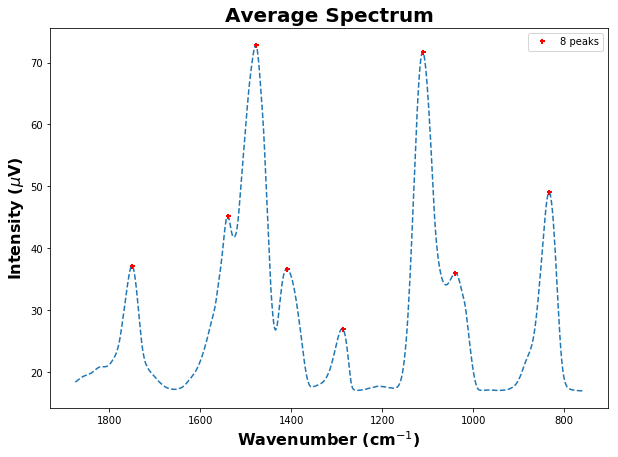

In [17]:
indices, peaksdict = FindPeaks.FindPeaks(averagespectrum, thres=0.1, min_dist=1)

from peakutils import plot

plt.figure(figsize=(10,7))
plot.plot(hyperimage.wavelength_data,averagespectrum*10**6, peaklocs)
plt.gca().invert_xaxis()
plt.title('Average Spectrum', fontweight='bold', fontsize = 20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontweight = 'bold', fontsize = 16)
plt.ylabel('Intensity ($\mu$V)', fontweight='bold', fontsize = 16)
plt.rc('xtick.major', size=5, pad=7)
plt.savefig('AverageSpectrum.png')
list_wavenumber = []
for i in range(len(indices)): 
    list_wavenumber.append(hyperimage.wavelength_data[indices[i]])
for i, el in enumerate(list_wavenumber):
    list_wavenumber[i] = int(el)

In [20]:
list_wavenumber

[1751, 1539, 1477, 1409, 1287, 1111, 1039, 833]

List of wavenumbers identified as peaks

In [ ]:
list_laser_std = stdfeature(list_laser, axis=0)
mean1 = list_laser_std.mean(axis=0)
var1 = list_laser_std.std(axis=0)

In [18]:
#standardize feature matrix to unit variance and zero mean 
featurematrix = makefeaturematrix(hyper[35:245, 25:245, :], averagespectrum)
featurematrix_std = stdfeature(featurematrix, axis = 0)
mean = featurematrix_std.mean(axis=0)
variance = featurematrix_std.std(axis=0)

### Feature matrix with entire spectrum: 

In [19]:
def fullspect_ft(spectralmatrix):
    xaxis = spectralmatrix.shape[0]
    yaxis = spectralmatrix.shape[1]
    zaxis = spectralmatrix[0,0,:].shape[0]
    featurematrix = np.zeros((xaxis*yaxis, zaxis))
    counter = -1
    #loop over elements in spectralmatrix 
    for x in range(xaxis):
        for y in range(yaxis):
            counter +=1 
            for z in range(zaxis):
                featurematrix[counter]=(spectralmatrix[x,y,:])
    
    return featurematrix

specfeat = fullspect_ft(hyper[35:245, 25:245, :])
specfeat_std = stdfeature(specfeat, axis = 0)

### matlab PCA on specfeat: PC1

In [ ]:
z = np.dot(specfeat_std, Skloadings.T)
zreshape = z.reshape(256,256, 8)
z0_std = zreshape[:,:,0].std()
z0_mean = zreshape[:,:,0].mean()
zll = z0_mean - (2*z0_std)
zul = z0_mean + (2*z0_std)
#first PC
plt.imshow(zreshape[:,:,0])
plt.clim(zll,zul)

In [ ]:
#define number of principal components 
sklearn_pca = sklearnPCA(n_components=8)

#matrix with each sample in terms of the PCs
SkPC = sklearn_pca.fit_transform(specfeat_std)

#covariance matrix 
Skcov = sklearn_pca.get_covariance()

#loadings
Skloadings = sklearn_pca.components_

#score matrix 
Skscore = sklearn_pca.score_samples(specfeat_std)

#explained variance
Skvariance = sklearn_pca.explained_variance_
Skvarianceratio = sklearn_pca.explained_variance_ratio_

In [ ]:
SkPCreshape = SkPC.reshape(256,256,8)

In [ ]:
Skavg = SkPCreshape[:,:,0].mean()
Skstd = SkPCreshape[:,:,0].std()
Skll = Skavg - 2*Skstd
Skul = Skavg + 2*Skstd

plt.imshow(SkPCreshape[:,:,0])
plt.colorbar()
plt.clim(Skll, Skul)

In [ ]:
plt.scatter([0,1,2,3,4,5,6,7],Skloadings[0,:])

### Matlab's PCA 

In [22]:
mlvariance[0:65]

array([ 0.07626773,  0.03376499,  0.03170767,  0.02806161,  0.02636989,
        0.02619168,  0.02560264,  0.02538268,  0.02449555,  0.02411618,
        0.02351625,  0.02276454,  0.02256352,  0.02204767,  0.0220118 ,
        0.02095979,  0.02075607,  0.02035811,  0.02030381,  0.01957402,
        0.01890677,  0.01821676,  0.01795762,  0.01770317,  0.0167049 ,
        0.01617545,  0.01601123,  0.0154335 ,  0.01473631,  0.01395807,
        0.01341552,  0.01255157,  0.01223724,  0.01181362,  0.01139403,
        0.01121124,  0.01044165,  0.01002039,  0.00940103,  0.00906948,
        0.00875879,  0.00837268,  0.00783843,  0.00747832,  0.00699686,
        0.00668818,  0.00644134,  0.00629111,  0.00585769,  0.00557528,
        0.00523147,  0.00497193,  0.00467765,  0.00447665,  0.00418081,
        0.00410014,  0.00392886,  0.0036988 ,  0.00344383,  0.00328385,
        0.00311069,  0.00293583,  0.00281201,  0.00265193,  0.00257905])

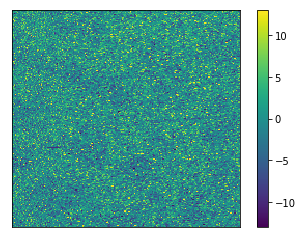

In [23]:
#with fullspec feat std 
mlPCA = PCA(specfeat_std)
#get projections of samples into PCA space
mltrans = mlPCA.Y
#reshape
mltransreshape = mltrans.reshape((210,220,559))
mltransreshape_flat0 = signal.detrend(mltransreshape[:,:,0], axis=1, type="linear")
mlloadings = mlPCA.Wt
mlvariance = mlPCA.fracs

mlavg = mltransreshape[:,:,0].mean()
mlstd = mltransreshape[:,:,0].std()
mlll = mlavg - 2*mlstd
mlul = mlavg + 2*mlstd
fig = plt.imshow(mltransreshape[:,:,1])
plt.colorbar()
plt.clim(mlll, mlul)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('PC1_scoreimage')

Project a different image onto the PCs derived from this image

In [ ]:
#project onto existing PCs 
z = np.dot(specfeat_std, mlloadings.T)

In [ ]:
z.shape

In [ ]:
mlavg = mltransreshape[:,:,1].mean()
mlstd = mltransreshape[:,:,1].std()
mlll = mlavg - 2*mlstd
mlul = mlavg + 2*mlstd
fig = plt.imshow(mltransreshape[:,:,1])
plt.colorbar()
plt.clim(mlll, mlul)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('PC2_scoreimage')

In [ ]:
mlavg = mltransreshape[:,:,2].mean()
mlstd = mltransreshape[:,:,2].std()
mlll = mlavg - 2*mlstd
mlul = mlavg + 2*mlstd
fig = plt.imshow(mltransreshape[:,:,2])
plt.colorbar()
plt.clim(mlll, mlul)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('PC3_scoreimage')

Loadings plot for PC1 when using entire spectrum; interesting

Find peaks in PC1 and store into list

In [26]:
pc1indices, pc1peaks = FindPeaks.FindPeaks(mlloadings[1,:], thres=0.1, min_dist=1)
pc1_wavenumber = []
for i in range(len(pc1indices)): 
    pc1_wavenumber.append(hyperimage.wavelength_data[pc1indices[i]])
for i, el in enumerate(pc1_wavenumber):
    pc1_wavenumber[i] = int(el)

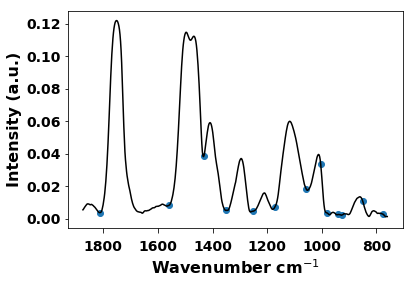

In [27]:
#show PC1 loading 'spectra' with peaks 
fig = plt.figure()
plt.plot(hyperimage.wavelength_data, mlloadings[0,:], color = 'black')
plt.scatter(pc1_wavenumber, mlloadings[0,pc1indices])
plt.gca().invert_xaxis()
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')
    tick.label1.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(14)
    tick.label1.set_fontweight('bold')
plt.xlabel('Wavenumber cm$^{-1}$', fontsize=16, fontweight='bold')
plt.ylabel('Intensity (a.u.)', fontsize=16, fontweight='bold')
fig.savefig('PC1 loading')

Find peaks for PC3, store into list

In [ ]:
pc3indices, pc3peaks = FindPeaks.FindPeaks(mlloadings[1,:], thres=0.1, min_dist=1)
pc3_wavenumber = []
for i in range(len(pc3indices)): 
    pc3_wavenumber.append(hyperimage.wavelength_data[pc3indices[i]])
for i, el in enumerate(pc3_wavenumber):
    pc3_wavenumber[i] = int(el)

In [ ]:
#show PC2 loading 'spectra' with peaks 
fig = plt.figure()
plt.plot(hyperimage.wavelength_data, mlloadings[2,:], color = 'black')
plt.scatter(pc3_wavenumber, mlloadings[2,pc3indices])
plt.scatter([1757, 1477], mlloadings[2,[59,199]], color = 'orange')
plt.gca().invert_xaxis()
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')
    tick.label1.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(14)
    tick.label1.set_fontweight('bold')
plt.xlabel('Wavenumber cm$^{-1}$', fontsize=16, fontweight='bold')
plt.ylabel('Intensity (a.u.)', fontsize=16, fontweight='bold')
fig.savefig('PC1 loading')

In [ ]:
pc3indices

In [ ]:
pc3_wavenumber

In [ ]:
plt.scatter(hyperimage.wavelength_data, mlloadings[1,:])
plt.gca().invert_xaxis()

In [ ]:
plt.scatter(hyperimage.wavelength_data, mlloadings[2,:])
plt.gca().invert_xaxis()

In [ ]:
plt.figure(figsize=(7,5))
fig = plt.scatter(list_wavenumber , mlloadings[0,:])
plt.title('Loadings Plot for PC2', fontweight='bold', fontsize = 16)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontweight = 'bold' , fontsize = 14)
plt.gca().invert_xaxis()
plt.ylabel('Loading', fontweight = 'bold', fontsize = 14)
plt.savefig('PC1loadings')

### Linear Regression

In [ ]:
sum(mlvariance[0:7])

In [28]:
regr = linear_model.LinearRegression()
#get variables in appropriate format
d = {}
training_x = []
for x in range(0, 4000): 
    d[x] = mltrans[x,0:63]
    training_x.append(d[x])
training_x = np.stack(training_x, axis=0)

In [29]:
mltrans.shape

(46200L, 559L)

In [30]:
test_x = []
d= {}
for x in range(0,46200): 
    d[x] = mltrans[x,0:63]
    test_x.append(d[x])
test_x = np.stack(test_x, axis=0)

In [ ]:
#for list of cAFM values of second set of images 
cAFMshiftlist = cAFM_transformed[60:225, 45:250].reshape((33825,1))

In [32]:
cAFMshiftlist = cAFM_transformed[35:245, 25:245].reshape((46200,1))
regr.fit(training_x, cAFMshiftlist[:4000])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [ ]:
#store intercepts and B values from regression
#B0 = regr.intercept_
#B0_1 = regr2.intercept_

#for i in range (1, 9): 
#    vars()['B'+str(i)] = regr.coef_[0,i-1]

#for i in range(1,9): 
#    vars()['B'+str(i)] = regr2.coef_[0,i-1]


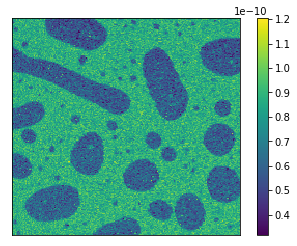

In [33]:
cAFMpred = regr.predict(test_x)
cAFMpredimage= cAFMpred.reshape(210,220)
#cAFMpredimage = cAFMpredimage[56:252,:]
fig=plt.imshow(cAFMpredimage)
plt.colorbar()
#mean = cAFMpredimage.mean()
#std = cAFMpredimage.std()
mean = cAFM[35:245,25:245].mean()
std = cAFM[35:245,25:245].std()
plt.clim(mean-2*std, mean+2*std)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('cAFMpredimage')

In [ ]:
fig=plt.imshow(cAFM1[60:225,45:250])
mean = cAFM1[60:225,45:250].mean()
std = cAFM1[60:225,45:250].std()
plt.clim(mean-2*std, mean+2*std)
#plt.clim(0.4e-10, 1.2e-10)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.colorbar()
plt.savefig('cAFMrealimage')

In [ ]:
error = cAFM_transformed[35:245, 25:245] - cAFMpredimage
fig = plt.imshow(error)
mean = error.mean()
std = error.std()
#plt.clim(mean-2*std, mean+2*std)
plt.colorbar()
#plt.clim(0.4e-10, 1.2e-10)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('error image')

In [ ]:
plt.plot(cAFMlist, 'o')
plt.ylim(0, 2e-10)
#plt.xlim(0, 0.1e-9)

In [ ]:
plt.subplot(311)
plt.scatter(PC1list,cAFMlist)
#plt.plot(training_x[:,0],regr2.predict(training_x),color='red',lw='3')
plt.ylabel('cAFM')
plt.xlabel('PC1')
plt.ylim(8e-15, 8e-10)

plt.subplot(312)
plt.scatter(PC2list,cAFMlist)
#plt.plot(training_x[:,1],regr2.predict(training_x),color='red',lw='3')
plt.ylabel('cAFM')
plt.xlabel('PC2')
plt.ylim(8e-20, 8e-10)

plt.subplot(313)
plt.scatter(PC3list,cAFMlist)
#plt.plot(training_x[:,2],regr2.predict(training_x),color='red')
plt.ylabel('cAFM')
plt.xlabel('PC3')
plt.ylim(8e-15, 6e-10)

plt.tight_layout()

In [ ]:
X1 = mltrans[:,0]
X2 = mltrans[:,1]
X = training_x[:,0:2]

xx1, xx2 = np.meshgrid(np.linspace(X1.min(), X1.max(), 200), 
                       np.linspace(X2.min(), X2.max(), 200))

z = B0 + B1*xx1 + B2*xx2

fig = plt.figure(figsize=(12,8))
ax = Axes3D(fig, azim=-115, elev=15)

#hyperplane
surf = ax.plot_surface(xx1, xx2, z, cmap=plt.cm.RdBu_r)

resid = cAFMlist[5000:] - regr.predict(training_x)
newX = np.concatenate((X,resid),1)


ax.scatter(newX[:,0], newX[:,1], newX[:,2] , color='black', alpha=1.0, facecolor='white')
#ax.scatter(newX[:,0], newX[:,1], newX[:,2] < 0 , color='black', alpha=1.0)
#ax.scatter(X1, X2, cAFMlist, color='black', alpha=1.0, facecolor='white')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('cAFM')

## Error Metrics


### Visually: Error Image

In [35]:
from sklearn.cluster import KMeans
import random

In [36]:
cAFMpair = np.zeros((46200,2))
cAFMpair = np.append(cAFMshiftlist, cAFMpred, axis=1)
cAFMerr = np.zeros((46200,1))
for i in range(cAFMpair.shape[0]): 
    cAFMerr[i]= (cAFMpair[i,0] - cAFMpair[i,1])

In [37]:
kmeans=KMeans(n_clusters=8).fit(cAFMerr)

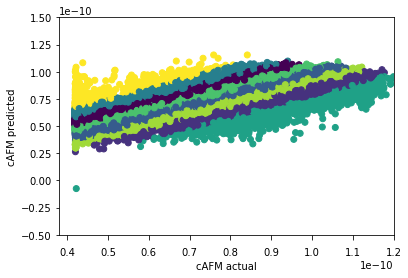

In [56]:
random.seed(12)
trans = kmeans.transform(cAFMerr)
y_pred = KMeans(n_clusters=8, random_state = 12).fit_predict(cAFMerr)
fig = plt.scatter(cAFMpair[:,0], cAFMpair[:,1], c= y_pred)
plt.xlim(0.38e-10, 1.2e-10)
plt.ylim(-0.5e-10, 1.5e-10)
plt.xlabel('cAFM actual')
plt.ylabel('cAFM predicted')
plt.savefig('clusterscatter')

In [104]:
cAFMerr.shape

(46200L, 1L)

In [102]:
cAFMpair.shape

(46200L, 2L)

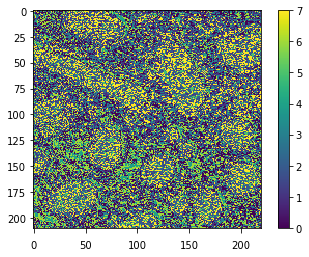

In [54]:
labelimage = np.reshape(kmeans.labels_, (210,220))
fig = plt.imshow(labelimage, cmap = 'viridis')
plt.colorbar()
plt.savefig('clusterimg')

#### get intercepts/slopes

In [ ]:
def betas(regr): 
    """Gets B0, B1, B2...etc from linear regression"""
    ncoefs = regr.coef_.shape[1] + 1 
    coefs = np.zeros((1,ncoefs))
    coefs[0] = regr.intercept_
    for i in range(regr.coef_.shape[1]):
        i += 1 
        coefs[0,i] = regr.coef_[0,(i-1)]
    return coefs

In [ ]:
coefs = betas(regr)
B0 = coefs[0,0]
B1 = coefs[0,1]
B2 = coefs[0,2]
#B3 = coefs[0,3]
#B4 = coefs[0,4]

#### Calculate RSS 

In [ ]:
def square(list):
    return [i ** 2 for i in list]

In [ ]:
#calc training RSS, TSS, and Rsquared
start = 0 #starting index in training data
end = 4000
x = cAFMshiftlist[start:end]
y = regr.predict(training_x)

z_train = []
for i in range(end-start):
    z_train.append(cAFMshiftlist[i] - regr.predict(training_x)[i])

RSS_train = sum(square(z_train))

TSS_train = sum((cAFMshiftlist[:end] - cAFMshiftlist[:end].mean())**2)

Rsquared_train = 1 - (RSS_train/TSS_train)
print(Rsquared_train)

In [ ]:
#calc test RSS, TSS, and Rsquared
start = 0 #starting index in training data
end = 33825
x = cAFMshiftlist[start:end]
y = regr.predict(test_x)

z_test = []
for i in range(33825):
    z_test.append(cAFMshiftlist[i] - regr.predict(test_x)[i])

RSS_test = sum(square(z_test))
TSS_test = sum((cAFMshiftlist[start:end] - cAFMshiftlist[start:end].mean())**2)
Rsquared_test = 1- (RSS_test/TSS_test)
print(Rsquared_test)

In [ ]:
Radj_num = (1-Rsquared_test)*(33824)
Radj_den = 33825-63-1
Radj = 1 - (Radj_num/Radj_den)
print(Radj)

In [ ]:
n = 4000 #no. of obvs used to train 
start_train = 0
end_train = 4000
start_test= end_train
end_test = 46200

MSE_train = mean_squared_error(cAFMshiftlist[start_train: end_train], cAFMpred[start_train:end_train])
MSE_test = mean_squared_error(cAFMshiftlist[start_test: end_test], cAFMpred[start_test:end_test])

RSE_train = (math.sqrt(RSS_train/((end_train-start_train)-2))) #RSE is an estimate of the the standard deviation in the population. 
RSE_test = (math.sqrt(RSS_test/((end_test-start_test)-2)))

std_train = RSE_train**2 
std_test = RSE_test**2


SEB0 = math.sqrt((std**2)*(1/n + (cAFMshiftlist[start:].mean()**2)/sum(((cAFMshiftlist[start:]-cAFMshiftlist[start:].mean())**2))))
SEB1num = std**2 
SEB1den = sum((mltrans[start:end,0]-mltrans[start:end,0].mean())**2)
SEB2den = sum((mltrans[start:end,1]-mltrans[start:end,1].mean())**2)
SEB3den = sum((mltrans[start:end,2]-mltrans[start:end,2].mean())**2)
SEB4den = sum((mltrans[start:end,3]-mltrans[start:end,3].mean())**2)
SEB1 = math.sqrt(SEB1num/SEB1den)
SEB2 = math.sqrt(SEB1num/SEB2den)
SEB3 = math.sqrt(SEB1num/SEB3den)
SEB4 = math.sqrt(SEB1num/SEB4den)

tB1 = regr.coef_[0,0]/SEB1 
tB2 = regr.coef_[0,1]/SEB2
#tB3 = regr.coef_[0,2]/SEB3 
#tB4 = regr.coef_[0,3]/SEB4
#trying bootstrap coefs:
#tB1 = B1/SEB1 
#tB2 = B2/SEB2
#tB3 = B3/SEB3 
#tB4 = B4/SEB4

#calc p values:
pB1=stats.t.sf(np.abs(tB1), n-1)*2
pB2=stats.t.sf(np.abs(tB2), n-1)*2
#pB3=stats.t.sf(np.abs(tB3), n-1)*2
print("P values are:", pB1, pB2)

In [ ]:
RSE_test

In [ ]:
B0ll = B2 - 2*SEB2
B0ul = B2 + 2*SEB2

np.set_printoptions(precision=12)
B0ll, B0ul

#### F-statistic

In [ ]:
predictors = 63
Fnumerator = (TSS_test-RSS_test)/predictors
Fdenominator = RSS_test/((33825)-predictors-1)
F= Fnumerator/Fdenominator
print(F, 'the p-value generated from the F-statistic is significant at level 0.05.')

In [ ]:
1-(RSS/TSS)

In [ ]:
RSS/TSS

## Bootstrap, Cross Validation

In [ ]:
import random

uses results from affine transformation/cropping in registration step. 

In [ ]:
def bootstrap(data, yact, samplesize, iterations):
    """This function draws bootstrap data sets that will be used to regress PCE onto V_OC, E_lumo, and mass with 
    each data set.
    
    It takes as parameters a dataset in the form of a pandas array, the sample size, and iterations (number
    of bootstrap samples of the specified sample size.) The function will return the MSE and the
    three relevant beta coefficients: B0, Bmass, Bvoc, Blumo."""
    #create variables to cumulative MSE, B0, Bmass, Bvoc, and Blumo. Divide by n at the end of everything to obtain 
    #average 
    cumulativeMSE=0
    cumulativeRSS=0
    TSS = 0
    cumulativeB0=0
    cumulativeB1=0
    cumulativeB2=0
    cumulativeB3=0
    cumulativeB4=0
    #initiate tuple of lists of running averages of MSE, intercept and betas
    runningaverages = ([], [], [], [], [], [], [], [], [], [])
    for i in range(iterations):
        #set up empty matrix with appropriate number of rows to store values for the 4 relevant variables 
        iDataSet=np.zeros((samplesize,6))
        for j in range(samplesize):
            #pick random sample
            row=random.randint(0,46199)
            iDataSet[j,0]=data[row,0]
            iDataSet[j,1]=data[row,1]
            iDataSet[j,2]=data[row,2]
            iDataSet[j,3]=data[row,3]
            iDataSet[j,4]=data[row,4]
            iDataSet[j, 5]=yact[row]
            #exit inner for loop, now that we have the data we want 
        #regress pce onto mass, voc, elumoalpha
        LinearRegr=linear_model.LinearRegression()
        #feed array into LinearRegr.fit to do multiple linear regression 
        LinearRegr.fit(iDataSet[:,0:4], iDataSet[:,5])


        cumulativeMSE += sum((iDataSet[:,5] - LinearRegr.predict(iDataSet[:, 0:4]))**2)/(samplesize)
        RSS = sum( i**2 for i in (iDataSet[:,5] - LinearRegr.predict(iDataSet[:, 0:4])))
        RSE = (math.sqrt(RSS/(40-2)))
        TSS = sum(i **2 for i in (iDataSet[:,5] - iDataSet[:,5].mean()))
        cumulativeB0 += LinearRegr.intercept_
        cumulativeB1 += LinearRegr.coef_[0]
        cumulativeB2 += LinearRegr.coef_[1]
        cumulativeB3 += LinearRegr.coef_[2]
        cumulativeB4 += LinearRegr.coef_[3]
        #take averages
        runningaverages[0].append(cumulativeMSE/(i+1))
        runningaverages[1].append(cumulativeB0/(i+1))
        runningaverages[2].append(cumulativeB1/(i+1))
        runningaverages[3].append(cumulativeB2/(i+1))
        runningaverages[4].append(cumulativeB3/(i+1))
        runningaverages[5].append(cumulativeB4/(i+1))
        runningaverages[6].append(RSS)
        runningaverages[7].append(TSS)
        runningaverages[8].append(RSE)
    return runningaverages

In [ ]:
data=mltrans
iterations=40
boot100=bootstrap(data, cAFMshiftlist, 100, iterations)
boot1000=bootstrap(data, cAFMshiftlist, 1000, iterations)
boot5000=bootstrap(data, cAFMshiftlist, 5000, iterations)
boot10000=bootstrap(data, cAFMshiftlist, 10000, iterations)

In [ ]:
Rsquared = (np.array(boot10000[7]) - np.array(boot10000[6]))/(np.array(boot10000[7]))
num = (1-Rsquared)*9999
denom = 9999-63-1
adjRsquared = 1 - num/denom
Rsquared

In [ ]:
Fnum = (np.array(boot5000[7]) - np.array(boot5000[6]))/5
Fdenom = np.array(boot5000[6])/(5000-5-1)
F = Fnum/Fdenom
F

In [ ]:
x=range(1,41)
plt.plot(x, boot100[0], color = "orange", label="100")
plt.plot(x, boot1000[0], color = "magenta", label="1000")
plt.plot(x, boot5000[0], color = "lightgreen", label="5000")
plt.legend(title = "Sample Size")
plt.xlabel("No iterations")
plt.ylabel("MSE")
plt.title("Running Average of MSE")

In [ ]:
#make figure
plt.figure(figsize=(20,15))
x=range(1,41)
#MSE plot
plt.subplot(221)
plt.plot(x, boot100[1], color = "orange", label="100")
plt.plot(x, boot1000[1], color = "magenta", label="1000")
plt.plot(x, boot5000[1], color = "lightgreen", label="5000")
plt.legend(loc="upper right", title ="Sample Size", fontsize="14")
plt.xlabel("No. of Iterations", fontsize="18")
plt.ylabel("Intercept", fontsize="18")
plt.title("Running Average of Intercept", fontsize="20")
#B_mass plot
plt.subplot(222)
plt.plot(x, boot100[2], color = "orange", label="100")
plt.plot(x, boot1000[2], color = "magenta", label="1000")
plt.plot(x, boot5000[2], color = "lightgreen", label="5000")
plt.legend(loc="lower right", title ="Sample Size", fontsize="14")
plt.xlabel("No. of Iterations", fontsize="18")
plt.ylabel("$B_{mass}$", fontsize="18")
plt.title("Running Average of B$_{mass}$", fontsize="20")
#B_VOC plot
plt.subplot(223)
plt.plot(x, boot100[3], color = "orange", label="100")
plt.plot(x, boot1000[3], color = "magenta", label="1000")
plt.plot(x, boot5000[3], color = "lightgreen", label="5000")
plt.legend(loc="upper right", title ="Sample Size", fontsize="14")
plt.xlabel("No. of Iterations", fontsize="18")
plt.ylabel("$B_{V_{OC}}$", fontsize="18")
plt.title("Running Average of $B_{V_{oc}}$", fontsize="20")
#B_LUMO plot
plt.subplot(224)
plt.plot(x, boot100[4], color = "orange", label="100")
plt.plot(x, boot1000[4], color = "magenta", label="1000")
plt.plot(x, boot5000[4], color = "lightgreen", label="5000")
plt.legend(loc="upper right", title ="Sample Size", fontsize="14")
plt.xlabel("No. of Iterations", fontsize="18")
plt.ylabel("B$_{LUMO}$", fontsize="18")
plt.title("Running Average of $B_{LUMO}$", fontsize="20")

In [ ]:
B0 = boot5000[1][39]
B1 = boot5000[2][39]
B2 = boot5000[3][39]
B3 = boot5000[4][39]
B4 = boot5000[5][39]